In [ ]:
#加载MNIST数据
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())
 
batch_size = 100 #一批数据的大小
n_iters= 6000 # 迭代次数（参数更新次数），一批数据用于一次迭代
num_epochs = n_iters / (len(train_dataset) / batch_size)#对全部数据进行训练的次数
num_epochs = int(num_epochs)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F

import math


cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(123)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(123)#在所有GPU上将用于生成随机数的种子设置为随机数

In [ ]:
#应用DataLoader存储数据，可实现随机打乱数据、批次化数据等功能
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [ ]:
#LSTM 单元
class LSTMCell(nn.Module):
  """
  LSTM cell
  """
  def __init__(self,input_size,hidden_size):
    super(LSTMCell,self).__init__()
    #初始化输入大小、隐层大小以及层参数
    self.input_size = input_size#28
    self.hidden_size = hidden_size#128
    self.x2h = nn.Linear(input_size, 4*hidden_size, bias=True)#28, 4*128
    self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=True)#128, 4*128
  
  def forward(self,x,hx,cx):
    # x: 100, 28
    #hx: 100, 128
    #cx: 100, 128
    #输入这一时刻的数据、上一时刻的隐状态及细胞状态
    #x = x.view(-1, x.size(1))
    gates = self.x2h(x) + self.h2h(hx)
    #gates = gates.squeeze()

    #分割成四部分
    ingate, forgetgate, cellgate, outgate = gates.chunk(4,1)#按照指定维度对张量进行分块
    ingate = F.sigmoid(ingate)
    forgetgate = F.sigmoid(forgetgate)
    cellgate = F.tanh(cellgate)
    outgate = F.sigmoid(outgate)
    #输出这一时刻的隐状态及细胞状态
    cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
    hy = torch.mul(outgate, F.tanh(cy))
    return hy,cy

In [ ]:
#LSTM
class LSTMModel(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim):
    super(LSTMModel,self).__init__()
    self.hidden_dim = hidden_dim
    self.lstm = LSTMCell(input_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
        #初始化 hidden state
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(x.size(0), self.hidden_dim))

        #初始化 cell state
        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(x.size(0), self.hidden_dim))    
       
        outs = []
        
        cn = c0#100,128
        hn = h0#100,128

        #x: 100, 28, 28
        for seq in range(x.size(1)):#对序列长度进行遍历
            hn, cn = self.lstm(x[:,seq,:],hn,cn)#x[:,seq,:] => 100,28
            outs.append(hn)
        #取最后的输出
        out = outs[-1].squeeze() 
        #经全连接层      
        out = self.fc(out) 
        return out

In [ ]:
#初始化模型

#把每张图片当作28*28的序列数据
seq_dim = 28 
input_dim = 28
hidden_dim = 128 
output_dim = 10
 
model =LSTMModel(input_dim, hidden_dim, output_dim)
  
if torch.cuda.is_available():
    model.cuda()
     
#损失器
criterion = nn.CrossEntropyLoss()
 
#优化器
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
#模型训练

loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        #批次化提取数据
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())#100，28，28
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
          
        #清空梯度
        optimizer.zero_grad()
         
        #计算损失
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        #梯度反向传播
        loss.backward()

        #梯度更新
        optimizer.step()
        
        #记录损失
        loss_list.append(loss.item())
        iter += 1
        
        #每500次打印一次
        if iter % 500 == 0:
            #计算准确率         
            correct = 0
            total = 0
            #取测试数据进行准确率测试
            for images, labels in test_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))
                
                #停止gradient计算
                with torch.no_grad():
                  outputs = model(images)
                  #取最大值所在下标为预测标签
                  _, predicted = torch.max(outputs.data, 1)
                  #所有测试数据进行计数
                  total += labels.size(0)
                  #预测准确的情况进行计数
                  correct += (predicted == labels).sum()
             
            accuracy = 100 * correct / total
             
            #打印Loss及accuracy
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration: 500. Loss: 2.2615997791290283. Accuracy: 18
Iteration: 1000. Loss: 1.0881155729293823. Accuracy: 65
Iteration: 1500. Loss: 0.5105134844779968. Accuracy: 82
Iteration: 2000. Loss: 0.23711372911930084. Accuracy: 89
Iteration: 2500. Loss: 0.2626453936100006. Accuracy: 94
Iteration: 3000. Loss: 0.199435293674469. Accuracy: 94
Iteration: 3500. Loss: 0.15696126222610474. Accuracy: 96
Iteration: 4000. Loss: 0.051122233271598816. Accuracy: 96
Iteration: 4500. Loss: 0.03645547106862068. Accuracy: 96
Iteration: 5000. Loss: 0.054254475980997086. Accuracy: 97
Iteration: 5500. Loss: 0.24952688813209534. Accuracy: 97
Iteration: 6000. Loss: 0.03582065925002098. Accuracy: 97


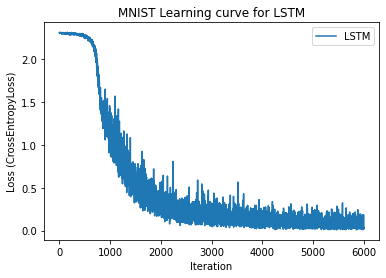

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel("Iteration")
plt.ylabel("Loss (CrossEntropyLoss)")
plt.title("MNIST Learning curve for LSTM")
plt.plot(loss_list, label="LSTM")
plt.legend()

torch.Size([100, 28, 28])
torch.Size([100, 28])
torch.Size([100, 28])
